In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import math
from pylab import *
from scipy.interpolate import interp1d
import time
from scipy.integrate import simps
import csv
from my_functions import *

In [2]:
filepath = './JPAS_Transmission_Curves_20170316/minijpas.Filter.csv'
filters_tags = []

with open(filepath, mode='r') as csvfile:
    rdlns = csv.reader(csvfile, delimiter=',')
    
    next(rdlns, None)
    next(rdlns, None)
    
    for line in rdlns:
        filters_tags.append(line[1])
        
filters_tags[0] = 'J0348'

In [3]:
filters_w = []
filters_trans = []

for tag in filters_tags:
    
    filename = './JPAS_Transmission_Curves_20170316/JPAS_'+tag+'.tab'
    f = open(filename, mode='r')
    lines = f.readlines()[12:]
    w = []
    trans = []
   
    for l in range(len(lines)):
        w.append(float(lines[l].split()[0]))
        trans.append(float(lines[l].split()[1]))
        
    filters_w.append(w)
    filters_trans.append(trans)
    
        
tcurves = {
    "tag"  :  filters_tags,
    "w"    :  filters_w ,
    "t"    :  filters_trans
}

Import the mocks

In [4]:
f_name = 'Source_cats/Source_cat_aaaa.npy'
mock = np.load( f_name, allow_pickle=True ).item()

In [5]:
# Import errors
errors = np.load('npy/errors5Sigma.npy')

In [6]:
w_central = []

for fil in range(0,len(tcurves['tag'])):
    w_c = sum(np.array(tcurves['w'][fil])*np.array(tcurves['t'][fil])) \
           / sum(tcurves['t'][fil])
    w_central.append(w_c)

In [7]:
def photo(mock_number): # Makes the photometry of mock #mock_number
    
    photo_len = len(tcurves['tag'])
    photo = np.zeros(photo_len)      # Initialize pm vector
    
    for fil in range(0,photo_len):   # For each filter
        
        w = np.array(tcurves['w'][fil])
        t = np.array(tcurves['t'][fil])
        
        f = interp1d(w, t, fill_value='extrapolate')
        w_Arr = mock['w_Arr']
        
        sed = f(w_Arr)*mock['SEDs'][mock_number]
                
        sed_int = simps(w_Arr*sed,w_Arr)
        t_int   = simps(w*t,w)
        
        err = np.random.normal()*errors[fil,1]
        
        photo[fil] = sed_int/t_int + err
        
    return np.array(photo)

# Photometry

In [8]:
N_sources = mock['SEDs'].shape[0]
N_filters = len(tcurves['tag'])

pm_data = np.zeros(N_filters*N_sources).reshape(-1,N_sources)

t_start = time.time()

for mock_n in range(N_sources):

    #pm = photo(mock_n)
    
    pm_data[:,mock_n] = photo(mock_n)
    
    print(str(mock_n)+'/'+str(N_sources), end='\r')

t_end = time.time()

print()
print('Elapsed time: ' + str(t_end-t_start))

16615/16616
Elapsed time: 2886.298440217972


In [9]:
np.save('npy/pm_e' + f_name[23:], pm_data)

In [10]:
bb_fwhm = [
    nb_fwhm(tcurves, -4, True),
    nb_fwhm(tcurves, -3, True),
    nb_fwhm(tcurves, -2, True),
    nb_fwhm(tcurves, -1, True)
]

In [11]:
for mock_n in range(60):
    
    if mock['LAE'][mock_n] == True:
        continue

    pm = photo(mock_n)
    
    plt.figure(figsize=(15,10))
    plt.plot( mock['w_Arr'], mock['SEDs'][mock_n], c='orange', lw=2, zorder=-1)
    plt.scatter(w_central[:-3], pm[:-3])
    plt.errorbar(w_central[:-3], pm[:-3], yerr=errors[:-3, 1], fmt='none')
    plt.scatter(w_central[8:15], pm[8:15], c='black')
    
    plt.scatter(w_central[-4], pm[-4], c='purple' , marker='s')
    plt.scatter(w_central[-3], pm[-3], c='green'  , marker='s')
    plt.scatter(w_central[-2], pm[-2], c='red'    , marker='s')
    plt.scatter(w_central[-1], pm[-1], c='dimgray', marker='s')
    
    plt.errorbar(w_central[-4], pm[-4], xerr=bb_fwhm[-4]/2, fmt='none', color='purple' , elinewidth=4)
    plt.errorbar(w_central[-3], pm[-3], xerr=bb_fwhm[-3]/2, fmt='none', color='green'  , elinewidth=4)
    plt.errorbar(w_central[-2], pm[-2], xerr=bb_fwhm[-2]/2, fmt='none', color='red'    , elinewidth=4)
    plt.errorbar(w_central[-1], pm[-1], xerr=bb_fwhm[-1]/2, fmt='none', color='dimgray', elinewidth=4)
    
    #plt.yscale('log')
    
    plt.xlabel('$\lambda\ (\AA)$', size=15)
    plt.ylabel('$f_\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)', size=15)    
    
    plt.show()
    
    print('N = '+str(mock_n))
    print('LAE = ' + str(mock['LAE'][mock_n]))

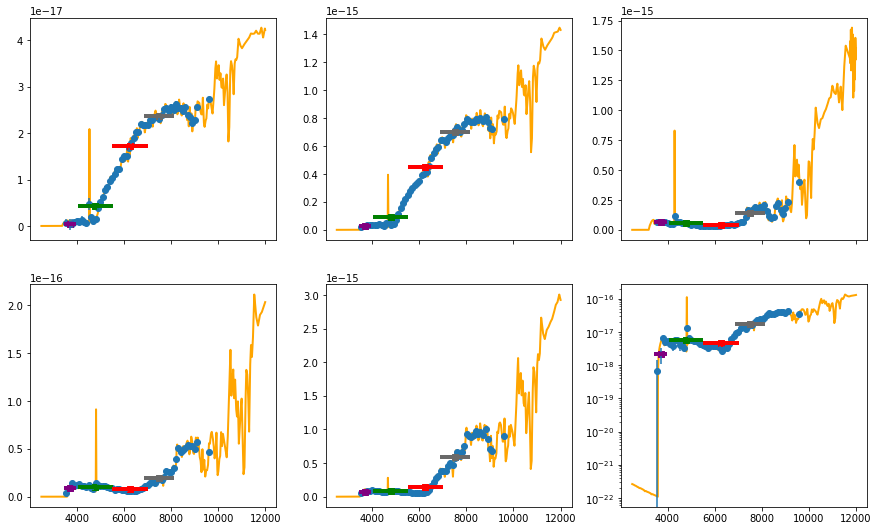

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(15, 9), sharex=True)

k=0
ns = [0, 1, 2, 3, 4, 5]
for i in [0, 1]:
    for j in [0, 1, 2]:
        pm = photo(ns[k])

        axs[i, j].plot( mock['w_Arr'], mock['SEDs'][ns[k]], c='orange', lw=2, zorder=-1)
        axs[i, j].scatter(w_central[:-3], pm[:-3])
        axs[i, j].errorbar(w_central[:-3], pm[:-3], yerr=errors[:-3, 1], fmt='none')

        axs[i, j].scatter(w_central[-4], pm[-4], c='purple' , marker='s')
        axs[i, j].scatter(w_central[-3], pm[-3], c='green'  , marker='s')
        axs[i, j].scatter(w_central[-2], pm[-2], c='red'    , marker='s')
        axs[i, j].scatter(w_central[-1], pm[-1], c='dimgray', marker='s')

        axs[i, j].errorbar(w_central[-4], pm[-4], xerr=bb_fwhm[-4]/2, fmt='none', color='purple' , elinewidth=4)
        axs[i, j].errorbar(w_central[-3], pm[-3], xerr=bb_fwhm[-3]/2, fmt='none', color='green'  , elinewidth=4)
        axs[i, j].errorbar(w_central[-2], pm[-2], xerr=bb_fwhm[-2]/2, fmt='none', color='red'    , elinewidth=4)
        axs[i, j].errorbar(w_central[-1], pm[-1], xerr=bb_fwhm[-1]/2, fmt='none', color='dimgray', elinewidth=4)
        plt.yscale('log')
        k += 1

plt.show()